<a href="https://colab.research.google.com/github/samitha278/multilayer-perceptron-char-lm/blob/main/mlp_char_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
from google.colab import files

uploaded = files.upload()


Saving names.txt to names.txt


In [4]:
words = open("names.txt","r").read().splitlines()

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

### Building dataset

In [6]:
block_size = 3


xs = []
ys = []


context = [0]*block_size



for w in words:

  for ch in w + '.':

    xs.append(context)
    next = stoi[ch]
    ys.append(next)


    context = context[1:] + [next]


x = torch.tensor(xs)
y = torch.tensor(ys)

In [7]:
x.shape,y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
x[:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

### Embedding

In [9]:
g = torch.Generator().manual_seed(2147483647)

In [10]:
C = torch.randn((27,2),generator=g,requires_grad=True)
C

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]], requires_grad=True)

In [11]:
C[5]

tensor([-0.4713,  0.7868], grad_fn=<SelectBackward0>)

In [12]:
C[torch.tensor([2,3,5,5,5])]

tensor([[ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [-0.4713,  0.7868],
        [-0.4713,  0.7868],
        [-0.4713,  0.7868]], grad_fn=<IndexBackward0>)

In [13]:
C[torch.tensor([[2,3],[3,2],[5,5],[2,5]])]

tensor([[[ 0.2859, -0.0296],
         [-1.5471,  0.6049]],

        [[-1.5471,  0.6049],
         [ 0.2859, -0.0296]],

        [[-0.4713,  0.7868],
         [-0.4713,  0.7868]],

        [[ 0.2859, -0.0296],
         [-0.4713,  0.7868]]], grad_fn=<IndexBackward0>)

In [14]:
emb = C[x]
emb.shape

torch.Size([228146, 3, 2])

In [15]:
x[1],C[[0,5]],emb[1]

(tensor([0, 0, 5]),
 tensor([[ 1.5674, -0.2373],
         [-0.4713,  0.7868]], grad_fn=<IndexBackward0>),
 tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]], grad_fn=<SelectBackward0>))

### Preparing input neurons to feed hidden layer

In [16]:
emb[:5]

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        [[-0.4713,  0.7868],
         [ 2.4448, -0.6701],
         [ 2.4448, -0.6701]],

        [[ 2.4448, -0.6701],
         [ 2.4448, -0.6701],
         [-0.0274, -1.1008]]], grad_fn=<SliceBackward0>)

In [17]:
emb[:5,0]

tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [-0.4713,  0.7868],
        [ 2.4448, -0.6701]], grad_fn=<SelectBackward0>)

In [18]:
torch.cat([emb[:5,0],emb[:5,1],emb[:5,2]],dim=1)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008]],
       grad_fn=<CatBackward0>)

In [19]:
torch.cat([emb[:,0],emb[:,1],emb[:,2]],dim=1).shape

torch.Size([228146, 6])

In [20]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([228146, 6])

### torch view and storage

In [21]:
a = torch.arange(12)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [22]:
a.storage()

/tmp/ipython-input-214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 12]

In [23]:
a.view(3,4)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [24]:
#only view has been changed memory allocation of a is same as before

# https://blog.ezyang.com/2019/05/pytorch-internals/

a.view(3,4).storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 12]

### Implementing hidden layer

In [25]:
W1 = torch.randn((6,100),generator=g,requires_grad=True)
b1 = torch.randn(100,generator=g,requires_grad=True)

In [26]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [27]:
h.shape , h

(torch.Size([228146, 100]),
 tensor([[-0.9348,  1.0000,  0.9258,  ...,  0.9786, -0.1926,  0.9515],
         [ 0.2797,  0.9997,  0.7675,  ...,  0.9929,  0.9992,  0.9981],
         [-0.9960,  1.0000, -0.8694,  ..., -0.5159, -1.0000, -0.0069],
         ...,
         [-0.4849,  0.9972, -0.6418,  ..., -0.9641,  0.9996,  0.9873],
         [-0.9318,  0.9926, -0.9841,  ..., -0.8989, -0.9938,  0.5930],
         [-0.9736,  0.3844, -0.8744,  ..., -0.5093,  0.9998, -0.9975]],
        grad_fn=<TanhBackward0>))

### Output layer

In [28]:
W2 = torch.randn((100,27),generator=g,requires_grad=True)
b2 = torch.randn(27,generator=g,requires_grad=True)

In [29]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

### Softmax

In [30]:
p = logits.exp()
p /= p.sum(1,keepdim=True)

p.shape

torch.Size([228146, 27])

### Loss

In [31]:
loss = -p[torch.arange(p.shape[0]),y].log().mean()
loss

tensor(19.2358, grad_fn=<NegBackward0>)

### Efficient way to calculate Loss

In [32]:
loss = F.cross_entropy(logits,y)
loss

tensor(19.2358, grad_fn=<NllLossBackward0>)

### Backpropagation

In [33]:
parameters = [C,W1,b1,W2,b2]

In [34]:
for p in parameters:

  #p.requires_grad = True
  #don't set requires_grad here → must be set at init time,
  #otherwise loss won't track this param in the graph

  #fixed it , remember it

  p.grad = None

In [35]:
loss.backward()

## What’s happening under the hood?

* When you create a parameter with requires_grad=True, PyTorch starts tracking
every operation involving it and builds a computation graph.

* During loss.backward(), PyTorch walks backward through this graph and fills in p.grad for each parameter.

* Gradients accumulate in .grad (they don’t overwrite). That’s why we set p.grad = None before each backward pass.

* If you accidentally set requires_grad=True after the forward pass, the computation graph was already built without tracking, so no grads flow → loss.backward() fails.

In [36]:
for p in parameters:
  p.data -= 0.01 * p.grad

### Forward pass

In [37]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1 )
logits = h @ W2 +b2
loss = F.cross_entropy(logits,y)
loss                  #decreased liltle bit

tensor(19.1409, grad_fn=<NllLossBackward0>)

# START OVER

In [131]:
x.shape , y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [132]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g,requires_grad=True)
W1 = torch.randn((6,100),generator=g,requires_grad=True)
b1 = torch.randn(100,generator=g,requires_grad=True)
W2 = torch.randn((100,27),generator=g,requires_grad=True)
b2 = torch.randn(27,generator=g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [133]:
sum([p.nelement() for p in parameters])    #parameters

3481

In [134]:
losses = []
steps = []

In [135]:
for i in range(100):


  #forward
  emb = C[x]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits,y)
  #print(loss.item())

  #backward
  for p in parameters:
    p.grad = None

  loss.backward()

  losses.append(loss.item())
  steps.append(i)

  #update
  for p in parameters:
    p.data -= 0.1 * p.grad



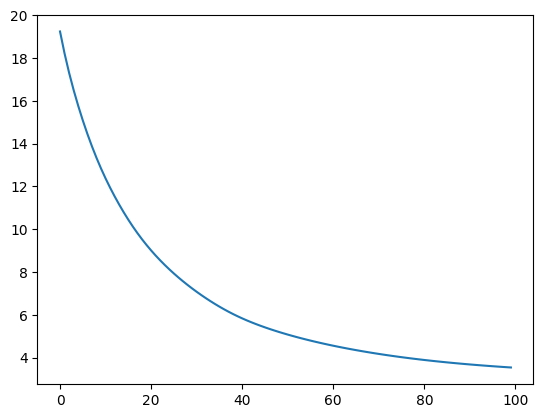

In [136]:
plt.plot(steps,losses)

### Using Minibatches

Mini-batches are used in training because:

* Full-batch gradient descent (using all data each step) gives the exact gradient but is slow.

* Mini-batch gradient descent (using a random subset of data) gives an approximation of the true gradient that is much faster to compute.

* This approximation is usually “good enough” to move the parameters in the right direction, and the randomness even helps escape local minima.

In [42]:
for _ in range(100):


  #minibatches
  ix = torch.randint(0,x.shape[0],(32,))


  #forward
  emb = C[x[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits,y[ix])
  print(loss.item())

  #backward
  for p in parameters:
    p.grad = None

  loss.backward()

  #update
  for p in parameters:
    p.data -= 0.1 * p.grad



3.5728275775909424
3.727341651916504
3.7163519859313965
4.072206020355225
2.739349365234375
3.550478219985962
3.3306729793548584
4.607418060302734
3.638533115386963
3.8557193279266357
3.7535576820373535
3.521111011505127
3.0870494842529297
3.742175579071045
3.671142101287842
3.365323066711426
4.208641529083252
3.011870861053467
3.4081642627716064
4.470665454864502
3.575873374938965
2.9311914443969727
3.5797152519226074
3.7647640705108643
4.210079669952393
4.397905349731445
3.8988609313964844
3.981323480606079
3.453437566757202
4.000040054321289
3.4671406745910645
2.962592840194702
4.0261993408203125
3.5317559242248535
3.158383369445801
3.4641377925872803
3.188533067703247
3.100071430206299
3.216815710067749
3.7667715549468994
2.869187593460083
4.817841529846191
3.289104700088501
3.246553421020508
3.102363348007202
2.5655477046966553
3.2277371883392334
3.0693438053131104
3.1363954544067383
3.2471370697021484
3.5177955627441406
3.1945462226867676
3.1512064933776855
2.8249666690826416
2.7

### Finding good initial learning rate

In [48]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

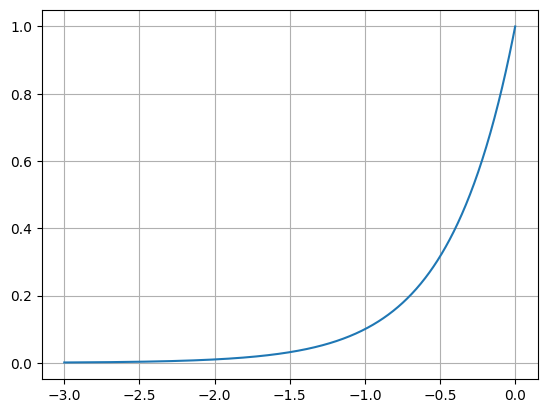

In [49]:
plt.plot(lre,lrs)
plt.grid()

### Reset

In [50]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g,requires_grad=True)
W1 = torch.randn((6,100),generator=g,requires_grad=True)
b1 = torch.randn(100,generator=g,requires_grad=True)
W2 = torch.randn((100,27),generator=g,requires_grad=True)
b2 = torch.randn(27,generator=g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [51]:
lri = []
losses = []


for i in range(1000):


  #minibatches
  ix = torch.randint(0,x.shape[0],(32,))


  #forward
  emb = C[x[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2

  loss = F.cross_entropy(logits,y[ix])
  #print(loss.item())

  #backward
  for p in parameters:
    p.grad = None

  loss.backward()

  lr = lrs[i]

  #update
  for p in parameters:
    p.data -= lr * p.grad


  #track stats
  losses.append(loss.item())
  lri.append(lr)



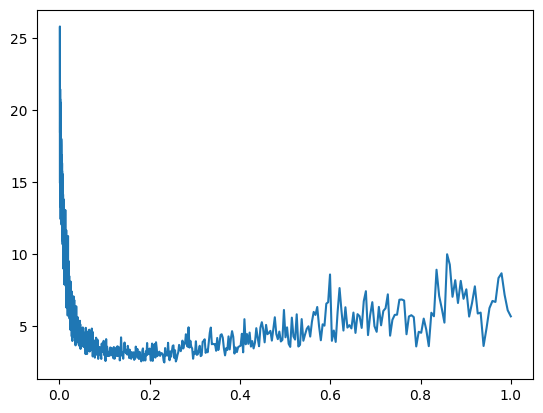

In [52]:
plt.plot(lri,losses)

In [53]:
# near o.1 is good learning rate , final stages of traning reduce learning rate

### Dataset Split
- **Train (80%)** → model learns patterns.  
- **Validation (10%)** → tune hyperparameters, prevent overfitting.  
- **Test (10%)** → final unbiased evaluation.  


In [54]:
block_size = 3

def build_dataset(words):

  xs,ys = [],[]

  context = [0]*block_size

  for w in words:
    for ch in w + '.':

      xs.append(context)
      next = stoi[ch]
      ys.append(next)

      context = context[1:] + [next]

  x = torch.tensor(xs)
  y = torch.tensor(ys)
  return x,y


In [55]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


xtr , ytr = build_dataset(words[:n1])
xdev ,ydev = build_dataset(words[n1:n2])
xte ,yte = build_dataset(words[n2:])


In [56]:
xtr.shape , ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

#### Train again using train split dataset

In [64]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g,requires_grad=True)
W1 = torch.randn((6,100),generator=g,requires_grad=True)
b1 = torch.randn(100,generator=g,requires_grad=True)
W2 = torch.randn((100,27),generator=g,requires_grad=True)
b2 = torch.randn(27,generator=g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [76]:
for i in range(100):

  #minibatch
  ix = torch.randint(0,xtr.shape[0],(32,))

  #forward
  emb = C[xtr[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,ytr[ix])

  #backward
  for p in parameters:
    p.grad = None

  loss.backward()

  #update
  for p in parameters:
    p.data -= 0.1 * p.grad


print(loss.item())

2.792816162109375


### evaluate loss : full training dataset

In [78]:
emb = C[xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits,ytr)
print(loss.item())

2.7529900074005127


### evaluate loss : dev dataset

In [79]:
emb = C[xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits,ydev)
print(loss.item())

2.755653142929077


### Underfitting

- Train loss ≈ Dev loss, but both are high → model underfitting.  
- Cause: too few parameters (low capacity).  
- Fix: add hidden units/layers, bigger embeddings, or train longer.  


### Try larger hidden layer

In [96]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g,requires_grad=True)
W1 = torch.randn((6,200),generator=g,requires_grad=True)
b1 = torch.randn(200,generator=g,requires_grad=True)
W2 = torch.randn((200,27),generator=g,requires_grad=True)
b2 = torch.randn(27,generator=g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [97]:
sum([p.nelement() for p in parameters])    #num of parameters

6881

In [98]:
losses = []
steps = []

In [108]:
for i in range(10000):

  #minibatch
  ix = torch.randint(0,xtr.shape[0],(32,))

  #forward
  emb = C[xtr[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,ytr[ix])

  #backward
  for p in parameters:
    p.grad = None

  loss.backward()

  #track loss
  losses.append(loss.item())
  steps.append(i)

  #update
  for p in parameters:
    p.data -= 0.001 * p.grad

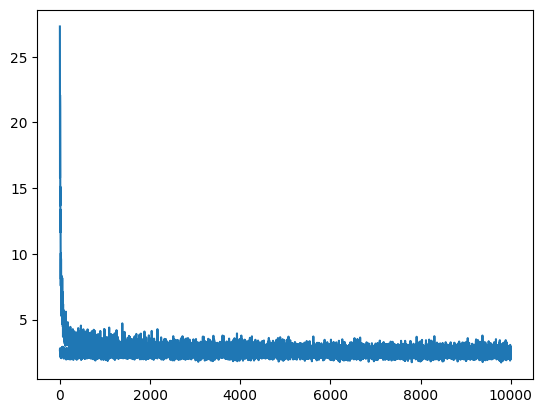

In [104]:
plt.plot(steps,losses)

### Why Loss Curves Look Noisy
- **Mini-batches** → different data each step causes fluctuations.  
- **High learning rate** → bigger jumps, more noise.  
- **Randomness** (init, dropout, shuffling) adds variability.  

### How to Reduce Noise
- Use a **moving average** or smoothing when plotting.  
- **Increase batch size** → more stable gradients.  
- **Lower learning rate** if too jumpy.  
- Run for **more epochs** → long-term trend becomes clearer.  

Noise is normal — focus on the **overall downward trend**.


In [109]:
# evaluate loss : full training dataset
emb = C[xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits,ytr)
print(loss.item())

2.37495493888855


In [110]:
# evaluate loss : dev dataset
emb = C[xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits,ydev)
print(loss.item())

2.373778820037842


### Visualizing character embedding

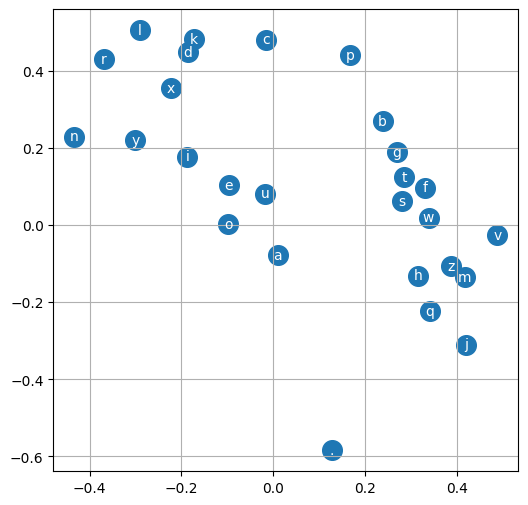

In [112]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### Try lager embedding size

In [118]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g,requires_grad=True)
W1 = torch.randn((30,200),generator=g,requires_grad=True)
b1 = torch.randn(200,generator=g,requires_grad=True)
W2 = torch.randn((200,27),generator=g,requires_grad=True)
b2 = torch.randn(27,generator=g,requires_grad=True)
parameters = [C,W1,b1,W2,b2]

In [115]:
sum([p.nelement() for p in parameters])    #num of parameters

11897

In [124]:
for i in range(20000):

  #minibatch
  ix = torch.randint(0,xtr.shape[0],(32,))

  #forward
  emb = C[xtr[ix]]
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,ytr[ix])

  #backward
  for p in parameters:
    p.grad = None

  loss.backward()

  #track loss
  losses.append(loss.item())
  steps.append(i)

  #update
  for p in parameters:
    p.data -= 0.1 * p.grad

In [125]:
# evaluate loss : full training dataset
emb = C[xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits,ytr)
print(loss.item())

2.45064377784729


In [126]:
# evaluate loss : dev dataset
emb = C[xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits,ydev)
print(loss.item())

2.46928334236145
